#### Business Question 2: Score prediction

In [0]:
# import packages
import os
import re
import sys
import nltk
import math
import sparknlp
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.sql import *
from sparknlp.base import *
from sparknlp.common import *
from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from sparknlp.annotator import *
from collections import ChainMap
import plotly.graph_objects as go
import pyspark.sql.functions as f
from nltk.corpus import stopwords
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline, Model
from datetime import datetime, timedelta
from pyspark.ml.regression import GBTRegressor
from pyspark.sql.functions import collect_list
from pyspark.sql.functions import array_remove
from pyspark.ml.regression import LinearRegression
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import col,sum,avg,max,count
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.types import ArrayType,StringType,IntegerType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator


In [0]:
# read from submission data
ml_df = spark.read.parquet('/FileStore/ML_preparing')
ml_df.printSchema()

root
 |-- idx: long (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- author: string (nullable = true)
 |-- score: long (nullable = true)
 |-- hide_score: boolean (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- gilded: long (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- created_utc: long (nullable = true)
 |-- selftext: string (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- disable_comments: boolean (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- result: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- text_length: integer (nullable = true)



In [0]:
# show the dataframe
ml_df.show(5)

In [0]:
# Check missing values & feature selection
drop_list = ['idx','author', 'created_utc', 'selftext', 'result']
ml_df_2 = ml_df.select([column for column in ml_df.columns if column not in drop_list])
ml_df_2.select([count(when(col(c).contains('None') | \
                           col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull(), c 
                           )).alias(c)
                    for c in ml_df_2.columns]).show()

+---------+-----+----------+-------+--------+------+-------------+--------+------------+----------------+-----------+----+-----------+
|subreddit|score|hide_score|over_18|is_video|gilded|distinguished|stickied|num_comments|disable_comments|day_of_week|hour|text_length|
+---------+-----+----------+-------+--------+------+-------------+--------+------------+----------------+-----------+----+-----------+
|        0|    0|         0|      0|       0|     0|       289397|       0|           0|          289558|          0|   0|          0|
+---------+-----+----------+-------+--------+------+-------------+--------+------------+----------------+-----------+----+-----------+



In [0]:
# Drop columns "distinguished" and "disable_comments" since they have too many missing values
ml_df_2 = ml_df_2.drop('distinguished').drop('disable_comments')

#### transformations

In [0]:
# check schema
ml_df_2.printSchema()

In [0]:
# perform the string index method
stringIndexer_subreddit = StringIndexer(inputCol="subreddit", outputCol="subreddit_ix")
stringIndexer_day_of_week = StringIndexer(inputCol="day_of_week", outputCol="day_of_week_ix")

In [0]:
# check number of levels of column "subreddit". It only has 2 levels, not perform the one hot encoder
stringIndexer_subreddit.fit(ml_df_2).labels
#onehot_subreddit = OneHotEncoder(inputCol=stringIndexer_subreddit.getOutputCol(), outputCol="subreddit_vec")

Out[7]: ['Minecraft', 'leagueoflegends']

In [0]:
# perform one hot encoding
onehot_day_of_week = OneHotEncoder(inputCol=stringIndexer_day_of_week.getOutputCol(), outputCol="day_of_week_vec")

In [0]:
# perform the vector assembler
vectorAssembler_features = VectorAssembler(
    inputCols=["subreddit_ix", "hide_score", "over_18", "is_video", "gilded", "stickied", "num_comments", "day_of_week_vec", "hour", "text_length"], 
    outputCol= "features")

#### Bonus: Pipeline

In [0]:
# perform pipeline
pipeline_base = Pipeline(stages=[stringIndexer_subreddit, 
                                 stringIndexer_day_of_week, 
                                 onehot_day_of_week,
                                 vectorAssembler_features])

In [0]:
# fit the pipeline and transform the data
output = pipeline_base.fit(ml_df_2).transform(ml_df_2)

In [0]:
# perform the output printschema
output.printSchema()

In [0]:
# split the train, test data
train_data, test_data = output.randomSplit([0.8, 0.2], 1234)

#### GBoost Tree Regressor

In [0]:
# perform the GBTRegression
GBT = GBTRegressor(featuresCol="features", labelCol="score", maxDepth=3, stepSize=0.2,  maxIter=50)

In [0]:
# fit the train data
GBT = GBT.fit(train_data)
GBT_result = GBT.transform(test_data)

In [0]:
# evaluate the RMSE, MAE, R2 of the GBT
rmse_GBT = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse_GBT = rmse_GBT.evaluate(GBT_result)
mae_GBT = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="mae")
mae_GBT = mae_GBT.evaluate(GBT_result)
r2_GBT = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2_GBT = r2_GBT.evaluate(GBT_result)

print("GBT_RMSE: ", rmse_GBT)
print("GBT_MAE: ", mae_GBT)
print("GBT_R-squared: ", r2_GBT)

GBT_RMSE:  526.1919769278501
GBT_MAE:  69.87057665430507
GBT_R-squared:  0.3933593658046708


In [0]:
# get the sample of GBT
sample_GBT = GBT_result.sample(0.17, 1234)

In [0]:
# get the select score and prediction and convert to pandas
sample_GBT = sample_GBT.select('score','prediction').toPandas()

In [0]:
# perform the log transformation
lst_score = []
lst_pred = []
for i in range(len(sample_GBT)):
    temp_score = float(sample_GBT.iloc[i]["score"])
    temp_pred = float(sample_GBT.iloc[i]["prediction"])
    if temp_score > 0:
        lst_score.append(math.log(temp_score))
    elif temp_score < 0:
        lst_score.append(-math.log(-temp_score))
    else:
        lst_score.append(0)
    if temp_pred > 0:
        lst_pred.append(math.log(temp_pred))
    elif temp_pred < 0:
        lst_pred.append(-math.log(-temp_pred))
    else:
        lst_pred.append(0)

#### Linear Regression

In [0]:
# perform the Linear Regression
MLR = LinearRegression(featuresCol="features", labelCol="score", maxIter=10, standardization=True)

In [0]:
# fit the train data
MLR = MLR.fit(train_data)

In [0]:
# transform the test data
LR_result = MLR.transform(test_data)

In [0]:
# show the Linear Regression results
LR_result.select('score','features','prediction').show(5,truncate= False)

+-----+-------------------------+-------------------+
|score|features                 |prediction         |
+-----+-------------------------+-------------------+
|0    |(15,[14],[36.0])         |-8.124908028742695 |
|0    |(15,[13,14],[5.0,2.0])   |-12.602307454887306|
|0    |(15,[13,14],[21.0,22.0]) |-10.577759554922267|
|0    |(15,[13,14],[21.0,120.0])|1.8641515804467073 |
|0    |(15,[13,14],[22.0,31.0]) |-9.46729866526517  |
+-----+-------------------------+-------------------+
only showing top 5 rows



In [0]:
# perform the RMSE, MAE, R2 evaluation to Linear Regression
rmse_LR = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse_LR = rmse_LR.evaluate(LR_result)
mae_LR = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="mae")
mae_LR = mae_LR.evaluate(LR_result)
r2_LR = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2_LR = r2_LR.evaluate(LR_result)

print("LR_RMSE: ", rmse_LR)
print("LR_MAE: ", mae_LR)
print("LR_R-squared: ", r2_LR)

LR_RMSE:  553.3742665624941
LR_MAE:  83.43155295243157
LR_R-squared:  0.32906419044606694


In [0]:
# get the sample of Linear Regression
sample_LR = LR_result.sample(0.17,seed = 1234)

In [0]:
# select the score and prediction columns and convert to pandas
sample_LR = sample_LR.select('score','prediction').toPandas()

In [0]:
# perform the log transformation
lst_pred_lr = []
for i in range(len(sample_LR)):
    temp_pred = float(sample_LR.iloc[i]["prediction"])
    if temp_pred > 0:
        lst_pred_lr.append(math.log(temp_pred))
    elif temp_pred < 0:
        lst_pred_lr.append(-math.log(-temp_pred))
    else:
        lst_pred_lr.append(0)

#### Random Forest Regression

In [0]:
# get the random forest regression and train the data and fit the test data into it
RF = RandomForestRegressor(featuresCol="features", labelCol="score", numTrees=10, maxDepth=30, seed=1234)
RF = RF.fit(train_data)
RF_result = RF.transform(test_data)

In [0]:
# perform the RMSE, MAE and R2 for the random forest
rmse_RF = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rmse_RF = rmse_RF.evaluate(RF_result)
mae_RF = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="mae")
mae_RF = mae_RF.evaluate(RF_result)
r2_RF = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="r2")
r2_RF = r2_RF.evaluate(RF_result)

print("RF_RMSE: ", rmse_RF)
print("RF_MAE: ", mae_RF)
print("RF_R-squared: ", r2_RF)

RF_RMSE:  494.28438094800396
RF_MAE:  63.75447604054251
RF_R-squared:  0.4647005123909188


In [0]:
# transfer to pandas and perform the log trasnformation
sample_RF = RF_result.sample(0.17,seed = 1234)
sample_RF = sample_RF.select('score','prediction').toPandas()

lst_pred_rf = []
for i in range(len(sample_RF)):
    temp_pred = float(sample_RF.iloc[i]["prediction"])
    if temp_pred > 0:
        lst_pred_rf.append(math.log(temp_pred))
    elif temp_pred < 0:
        lst_pred_rf.append(-math.log(-temp_pred))
    else:
        lst_pred_rf.append(0)

In [0]:
# feature importance
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [0]:
# show the feature importance
ExtractFeatureImp(RF.featureImportances, RF_result, "features")[['idx','name','score']].head(10)

,idx,name,score
5,6,num_comments,0.470688
3,4,gilded,0.248976
7,14,text_length,0.086124
6,13,hour,0.082685
8,0,subreddit_ix,0.023923
13,11,day_of_week_vec_Tue,0.017669
9,7,day_of_week_vec_Sun,0.016210
12,10,day_of_week_vec_Thu,0.014549
10,8,day_of_week_vec_Wed,0.010401
2,3,is_video,0.009617


#### Evaluate Model Performance

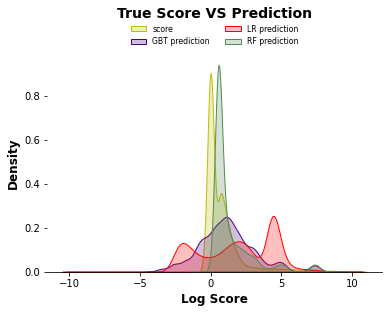

In [0]:
# evaluate three models, GBT, LR, RF prediction and show the graphs
fig = sns.kdeplot(lst_score, shade=True, color="y", label='score')
fig = sns.kdeplot(lst_pred, shade=True, color="#4B0082", label='GBT prediction')
fig = sns.kdeplot(lst_pred_lr, shade=True, color="#FF0000", label='LR prediction')
fig = sns.kdeplot(lst_pred_rf, shade=True, color="#548B54", label='RF prediction')
plt.legend(loc='upper center',frameon=False,ncol=2,bbox_to_anchor=(.5, 1.17),prop={'size': 7.7})
plt.title('True Score VS Prediction',weight='bold',y=1.14).set_fontsize('14')
plt.xlabel('Log Score',weight='bold').set_fontsize('12')
plt.ylabel('Density', weight='bold').set_fontsize('12')
sns.despine(left=True)
plt.savefig('../../data/plots/regression_eval.png', dpi=160, bbox_inches='tight')
plt.show()

In [0]:
# save model
LinearRegression.save(MLR,'/FileStore/ML_model/MLR')

In [0]:
# save model
GBTRegressor.save(GBT,'/FileStore/ML_model/GBT')

In [0]:
# save model
RandomForestRegressor.save(GBT,'/FileStore/ML_model/RF')

In [0]:
#! rm -rf /dbfs/FileStore/ML_model/GBT
#! rm -rf /dbfs/FileStore/ML_model/MLR